In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))

/tmp/ipykernel_15336/456513685.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# GANs N' Roses: Understanding Generative Models

## About Me

I taught machine learning and distributed computing technologies at Data Science Retreat, the longest-running Berlin-based bootcamp, for more than three years, helping more than 150 students advance their careers.

My professional background includes 20 years of experience working for companies in several industries: banking, government, fintech, retail and mobility.

I write regularly for Towards Data Science. My blog post ["Understanding PyTorch with an example: a step-by-step tutorial"](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e) reached more than 300,000 views since it was published.

The positive feedback from the readers motivated me to write the series of book ["Deep Learning with PyTorch Step-by-Step: A Beginner's Guide"](https://pytorchstepbystep.com), which covers a broader range of topics.

## Introduction: DeepFakes, GANs, and Synthetic data

Generative models are at the heart of DeepFakes, and can be used to synthesize, replace, or swap attributes of images.

In this workshop, we will learn the basics of Generative Adversarial Networks, the famous GANs, from the ground up: latent spaces, autoencoders, generators, discriminators, GANs, DCGANs, WGANs, and more.

The main goal of this sessions is to show you how GANs work: we will start with a simple example using synthetic data (not generated by GANs) to learn about latent spaces and how to use them to generate more synthetic data (using GANs to generate them). We will improve on the model's architecture, incorporating convolutional layers (DCGAN), different loss functions (WGAN, WGAN-GP) and use them to generate synthetic images of flowers (the roses!).

We will use Google Colab and work our way together into building and training several GANs. You should be comfortable using Jupyter notebooks and Numpy, and training simple models in PyTorch.


### DeepFakes

**What** are DeepFakes?

---

"Deepfakes are synthetic media in which a person in an existing image or video is replaced with someone else's likeness." 

[Wikipedia](https://en.wikipedia.org/wiki/Deepfake)

---

There are three main types of fakes:

1. Face Synthesis (StyleGAN)
   - https://www.thispersondoesnotexist.com/
   - https://github.com/lucidrains/stylegan2-pytorch
   - https://github.com/lucidrains/lightweight-gan
   

2. Face Swap (AutoEncoders)
   - https://github.com/deepfakes/faceswap
   - https://github.com/iperov/DeepFaceLive
   

3. Manipulating Face Attributes and Expressions (StarGAN)
   - https://github.com/streamlit/demo-face-gan
   
The images below were generated using https://www.thispersondoesnotexist.com/

|  |  |  |  |  |
|---|---|---|---|---|
| ![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/tpdne1.jpeg) | ![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/tpdne2.jpeg) | ![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/tpdne3.jpeg) | ![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/tpdne4.jpeg) | ![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/tpdne5.jpeg) |

## GANs

The ability to generate synthetic images or manipulate existing ones has been greatly improved by one particular development: the rise of Generative Adversarial Networks. In its seminal paper, ["Generative Adversarial Networks"](https://arxiv.org/abs/1406.2661), Ian Goodfellow et al. introduced a clever, yet simple idea: pitting one neural network against the other!

One of the networks plays the role of a **forger**, trying to fool the other network, which plays the role of an **appraiser** that's constantly looking for clues that a given image might be a forgery.

So, as the forger gets better at generating believable fakes, the appraiser needs to up its game to keep up with it, and so on and so forth.

Nowadays, there are *countless* types of GANs - they are versatile, and researches have proposed modifications to the original architecture to accomplish different tasks. While extremely versatile, GANs are also known to be somewhat *finicky* and hard to train.

If you're curious about the different types of GANs out there, check the [GAN ZOO](https://github.com/hindupuravinash/the-gan-zoo) out!

## An MNIST-like Dataset of Circles

In [2]:
!curl https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/gans.py --output gans.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11267  100 11267    0     0   171k      0 --:--:-- --:--:-- --:--:--  171k


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
from gans import *

In [3]:
def draw_circle(radius, center_x=0.5, center_y=0.5, size=28):
    # draw a circle using coordinates for the center, and the radius
    circle = plt.Circle((center_x, center_y), radius, color='k', fill=False)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.add_patch(circle)
    ax.axis('off')
    buf = fig.canvas.print_to_buffer()
    plt.close()
    # converts matplotlib figure into PIL image, make it grayscale, and resize it
    return np.array(Image.frombuffer('RGBA', buf[1], buf[0]).convert('L').resize((int(size), int(size))))

def gen_circles(n, size=28):
    # generates random coordinates around (0.5, 0.5) as center points
    center_x = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    center_y = np.random.uniform(0.0, 0.03, size=n).reshape(-1, 1)+.5
    # generates random radius sizes between 0.03 and 0.47
    radius = np.random.uniform(0.03, 0.47, size=n).reshape(-1, 1)
    sizes = np.ones((n, 1))*size

    coords = np.concatenate([radius, center_x, center_y, sizes], axis=1)
    # generates circles using draw_circle function
    circles = np.apply_along_axis(func1d=lambda v: draw_circle(*v), axis=1, arr=coords)
    return circles, radius

np.random.seed(42)
# generates 1,000 circles
circles, radius = gen_circles(1000)

circles_ds = TensorDataset((torch.as_tensor(circles).unsqueeze(1).float()/255-.5)/.5, torch.as_tensor(radius))
circles_dl = DataLoader(circles_ds, batch_size=32, shuffle=True, drop_last=True)

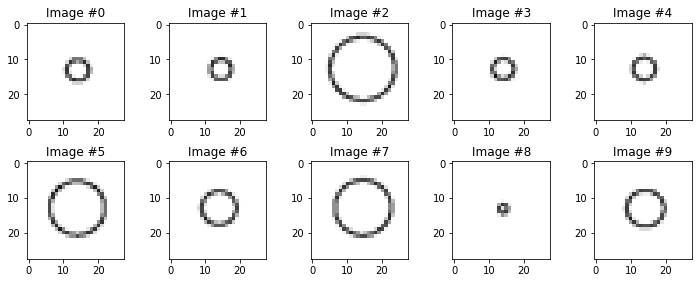

In [4]:
fig = figure1(circles_ds)

In [5]:
input_shape = (1, 28, 28)

## Module 1: Latent Spaces and AutoEncoders

## Latent Space

The latent space is a **vector** containing one value for each **dimension**. It is usually represented by the letter ***z***.

**YOU** get to choose how many dimensions the latent space will have!

![latent space](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/latent_space.png)

Let's keep it simple: our latent space has a **single dimension**.

In [6]:
z_size = 1
z = torch.randn((5, z_size)).float()
z

tensor([[-1.3481],
        [-1.3172],
        [ 1.3243],
        [ 0.7785],
        [-2.2753]])

You may be thinking, "*but **which** dimensions are that, what do they mean*".

### Embedding Dimensions

Just like **embeddings** in NLP, the learned representations in the latent space ***may*** have some meaning (this is not a guarantee, and we're the ones assigning *meaning* to a dimension.

<img src="https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/embed_arithmetic.png" width="800px"/>

The latent space, however many dimensions it may have, will be **sampled**, and then we'll use a given sample to **build an image**.

In other words, we'll sample from a known distribution (usually, standard Normal) for each and every dimension, just like this:

```python
torch.randn((1, z_size)).float()
```

**YES, it is random!**

## The Decoder

How do we go from a random vector to full image? How about using a **neural network**?

The **decoder** plays the role of **mapping the (normally-distributed) latent space (*z*)** to a completely different distribution, in this case, **images**!

![decoder](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/decoder_diagram.png)

So, let's build a simple sequential model in PyTorch that takes a **vector *z*** and outputs an **image** in the CHW shape.

In [7]:
decoder = nn.Sequential(
    # z_size -> 2048
    nn.Linear(z_size, 2048),
    nn.LeakyReLU(),
    # 2048 -> 2048
    nn.Linear(2048, 2048),
    nn.LeakyReLU(),
    # 2048 -> C*H*W
    nn.Linear(2048, np.prod(input_shape)),
    # C*H*W -> (C, H, W)
    nn.Unflatten(1, input_shape)
)

In [8]:
decoder

Sequential(
  (0): Linear(in_features=1, out_features=2048, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=2048, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=(1, 28, 28))
)

Let's double check that the decoder is doing its job:

In [9]:
x_tilde = decoder(z)
x_tilde.shape

torch.Size([5, 1, 28, 28])

(tensor([-1.3172]), None)

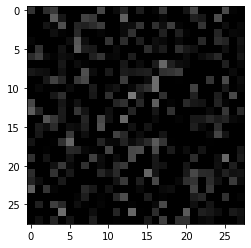

In [10]:
z[1], show(x_tilde[1])

Yeah... it converted a point in our one-dimensional latent space into an image.

Obviously, we don't need a decoder to generate images of *noise*, right?

It boils down to one question: **how do we get proper, meaningful, latent spaces?**

## Solution 1: The Encoder

If we're using a **decoder** to map from latent space to images, why not use an **encoder** to do exactly the opposite, that is, **map an image into the latent space (*z*)**?

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/encoder_diagram.png)

We're not going to actually build an encoder here, but an encoder could look like this:

`
Encoder(
  (base_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
  )
  (lin_latent): Linear(in_features=2048, out_features=1, bias=True)
)
`

### AutoEncoder

Guess what happens if we put the two of them together, an encoder and a decoder?

That's an **autoencoder**! It works like this:

- it takes **an image** as **input**
- the **encoder** part **maps the image to a latent space (*z*)
- the **latent space** is the **input of the decoder** part
- the **decoder** part **maps the latent space (*z*) back to an image**

The **goal** of the autoencoder is to **reconstruct the images**, so, the **generated image** is as close as possible to the original one.

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/ae_diagram.png)

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        
    def forward(self, x):
        # when encoder met decoder
        enc_out = self.enc(x)
        return self.dec(enc_out)

There's **so** much more to autoencoders! The **variational** flavor of autoencoders, for example, can be used to **generate data** that's not completely limited by the data available in the training set. 

But we're just using them as a example, since they represent **one way to tackle** our main question "*how do we get proper, meaningful, latent spaces*".

Guess what the **other way** is?

## Module 2: Your First GAN

Generative Adversarial Networks, GANs, provide a different, and quite interesting way to tackle the challenge of achieving proper, meaningful, latent spaces.

Let's take a closer look!

## Solution 2: Random Noise + Classifier

We start, once again, with a **random sample** from our latent space (*z*).

![latent space](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/latent_space.png)

In [12]:
def latent_sample(batch_size, z_size, mode_z='normal'):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size) * 2 - 1 # make it zero centered
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

This time, though, let's use a **latent space with 20 dimensions**, and generate a **mini-batch of vectors sampled from that latent space**.

In [13]:
z_size = 20

torch.manual_seed(1)
input_z = latent_sample(32, z_size, 'normal')
input_z[0], input_z.shape

(tensor([-1.5256, -0.7502, -0.6540, -1.6095, -0.1002, -0.6092, -0.9798, -1.6091,
         -0.7121,  0.3037, -0.7773, -0.2515, -0.2223,  1.6871,  0.2284,  0.4676,
         -0.6970, -1.1608,  0.6995,  0.1991]),
 torch.Size([32, 20]))

We'll use the samples from the latent space to, once again, **generate images** using the Decoder, now known as the **Generator**.

## The Generator (former Decoder)

![generator](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/generator.png)

The first GANs were built using fully-connected layers, like our decoder. But, soon enough, DCGANs (Deep Convolutional GANs) became the norm. Nowadays, a GAN is assumed to be a DCGAN (if we're handling images, of course). 

DCGANs were introduced in the paper ["Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks"](https://arxiv.org/abs/1511.06434) by Radford A. et al.

The paper prescribed some improvements on regular GANs:
 - Remove fully-connected layers
 - Use BatchNorm
 - Use Adam optimizer
 - Generator
   - Use ReLU activation in the Generator for all layers, except the output layer (Tanh)
   - Use transposed convolutions (they are like "inverse convolutions", we'll get to them soon!)
 - Discriminator (that's the **Classifier** from Solution 2's title)
   - Use strided convolutions instead of pooling layers
   - **Use LeakyReLU activation**
 
For more details on this, check Jason Brownlee's post on ["How to Train Stable Generative Adversarial Networks"](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/).

By the way, don't take the list above too literally - we'll see that some of them do not hold anymore.

In [14]:
set_seed(13)

z_size= 20
in_channels = 1
n_filters = 32

# z_size as channels of a single pixel!
generator = nn.Sequential(
    # z_size -> z_size@1x1
    nn.Unflatten(1, (z_size, 1, 1)),
    
    # z_size@1x1 -> 64@4x4
    nn.ConvTranspose2d(z_size, n_filters*2, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),

    # 64@4x4 -> 64@7x7
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),

    # 64@7x7 -> 32@14x14
    nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(0.2),

    # 32@14x14 -> in_channels@28x28
    nn.ConvTranspose2d(n_filters, in_channels, kernel_size=4, stride=2, padding=1),

    nn.Tanh()
)

What if we feed our mini-batch of random samples from the latent space to the generator?

In [15]:
x_tilde = generator(input_z)
x_tilde.shape

torch.Size([32, 1, 28, 28])

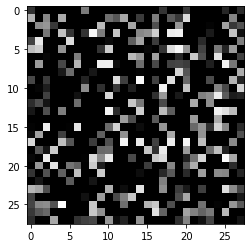

In [16]:
show(x_tilde[0])

Noise, just as before, after all, it's all random! To address this, we're **NOT** using an encoder, but a **classifier**, the **Discriminator**, instead.

Before moving on, though, let's take a quick look at the **unflatten** and **transposed convolution** layers in our **Generator**.

### Unflatten

The unflatten layer is transforming a **20-dimensional sample from the latent space** into a **20-channel single-pixel "image"**.

Making it a "pixel" allows us to use **transposed convolution** to **increase height and width** of our single-pixel image all the way up to the desired image size (1@28x28).

<img src="https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/unflatten_z.png" width="800px"/>

In [17]:
latent = torch.empty(5, z_size)
unflattener = nn.Unflatten(1, (z_size, 1, 1))
latent.shape, unflattener(latent).shape

(torch.Size([5, 20]), torch.Size([5, 20, 1, 1]))

### Transposed Convolution - Stride = 1

Transposed convolutions are a bit weird... they all have their own **padding (transposed)**, **stride (transposed)** and **kernel size** arguments, but there are **implicit arguments** too!

Let's start with the **implicit padding**, which is given by: `kernel size - padding(transposed) - 1`.

It goes like this:
- The original image gets **padded** with the **implicit padding**
- A **regular convolution** is performed on the padded image using the kernel/filter and **stride of one**.

Yeah, the **stride (transposed)** wasn't used at all! It will **only be used** if it is **greater than one**.

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/conv_transp_s1.png)

### Transposed Convolution - Stride = 2

If the **stride (transposed)** is greater than one, there's an **extra step** at the start: the input image gets **stuffed with zeros** by adding columns and rows full of zeroes **in-between the existing columns and rows**.

The number of **added columns/rows** is given by: `stride (transposed) - 1`.

BTW, the **implicit padding** is calculated just like before.

It goes like this:
- The original image gets **stuffed** with as many columns and rows full of zeros as given by the **stride (transposed) minus one**.
- The stuffed image gets **padded** with the **implicit padding**
- A **regular convolution** is performed on the padded image using the kernel/filter and **stride of one**.

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/conv_transp_s2.png)

If it's not clear yet, the code below should help you make sense of the operation.

In [18]:
import torch.nn.functional as F

input_image = torch.ones((1, 1, 2, 2)) # N, C, H, W
input_image

kernel_size = 2
kernel = torch.ones((1, 1, kernel_size, kernel_size))

stride_transp = 2
padding_transp = 0

F.conv_transpose2d(input_image,
                   weight=kernel,
                   stride=stride_transp,
                   padding=padding_transp)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

In [19]:
zero_added_image = torch.tensor([[[[1, 0, 1],
                                   [0, 0, 0],
                                   [1, 0, 1]]]]).float()

In [20]:
padding_implicit = kernel_size - padding_transp - 1
stride = 1

F.conv2d(zero_added_image,
         weight=kernel,
         stride=1,
         padding=padding_implicit)

tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])

### Transposed Convolution - Increasing Dimensions of the Outputs

The most important thing to remeber is that the **transposed convolution** is used to **increase height and weight** (and even channels, like a regular convolution does) of the output image.

$$
\Large \text{stride}^T \times (\text{image_size}-1) + \text{kernel_size} - 2 \times \text{padding}^T
$$

## The Classifier (aka Discriminator)

So, instead of an *encoder*, we'll be using a **classifier**, also known as, **Discriminator**.

Its job is fairly straightforward: classify a given image as either **real (1) or fake (0)**.

![discriminator](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/discriminator.png)

The class below takes a sequential model (`base_model`), figures its output size (assuming its flattened), and uses it as input to a **linear output layer with a sigmoid activation - a simple logistic regression**.

In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.base_model = base_model

        output_size = self._get_output_size()
        # appends the "lin_classifier" linear layer to map from "output_size" 
        # given by the base model to the output of a binary classifier
        output_size = self._get_output_size()
        self.lin_classifier = nn.Linear(output_size, 1)
        self.activation = nn.Sigmoid()

    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size
        
    def forward(self, x):
        # forwards the input through the base model and then the "lin_classifier" layer 
        # to get the representation (z)
        base_out = self.base_model(x)
        logits = self.lin_classifier(base_out)
        out = self.activation(logits)
        return out

The base model itself is a typical **convolutional neural network**. It takes our circle images as inputs (1@28x28), convolves them several times until their dimensions are 64@7x7, and flattens them for the classifier part.

In [22]:
set_seed(13)

# we defined our representation (z) as a vector of size twenty
z_size = 20
in_channels = 1
n_filters = 32
# our images are 1@28x28
input_shape = (1, 28, 28) # (C, H, W)

disc_base = nn.Sequential(
    # in_channels@28x28 -> 32@28x28
    nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(0.2),
            
    # 32@28x28 -> 64@14x14
    nn.Conv2d(n_filters, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@14x14 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 3136
    nn.Flatten(),
)


discriminator = Discriminator(input_shape, disc_base)

There's a **symmetry** between **discriminator** and **generator**. We should try to build them with similar complexity/power, in order to create a level playing field for them to compete.

In [23]:
discriminator

Discriminator(
  (base_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (lin_classifier): Linear(in_features=3136, out_

In [24]:
generator

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(20, 1, 1))
  (1): ConvTranspose2d(20, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2)
  (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.2)
  (10): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (11): Tanh()
)

## Generative Adversarial Network (GAN)

The GAN is simply a combination of Generator and Discriminator, like in the diagram below:

![gan](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/gan.png)

Now compare it to the architecture of the AutoEncoder below (and notice the colors I used). 

The **Decoder** and the **Generator** are performing the same operation, that is, **generating images**. 

Although the **Discriminator** and the **Encoder** are performing different operations, they share the **same architectural principle**, that is, being a **mirror-image** (of sorts) of their counterparts, respectively, the Generator and the Decoder.

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/ae_diagram.png)

In [25]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def forward(self, z):
        x_fake = self.generator(z)
        prob = self.discriminator(x_fake)
        return prob

In [26]:
gan = GAN(generator, discriminator)
gan

GAN(
  (generator): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(20, 1, 1))
    (1): ConvTranspose2d(20, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Tanh()
  )
  (discriminator): Discriminator(
    (base_model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


The models themselves, Discriminator and Generator, are quite straightforward, there's nothing special about them.

The **secret sauce** lies in the **training**!

<img src="https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/jonathan-borba-YRg1q2qCq8A-unsplash.jpg" />
<p style="text-align:center">
Photo by <a href="https://unsplash.com/@jonathanborba?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jonathan Borba</a> on <a href="https://unsplash.com/s/photos/sauce?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
</p>

## Training GAN

It turns out, one **does not train the whole GAN at once**. We **take turns**, training each part, **Discriminator** and **Generator**, alternately.

First, we train the Discriminator using **two batches** of images, **real** and **fake**, and their **true labels**.

Then we train the Generator using **fake images**, but use **labels as if they were real** (or **pretend labels**, as I like to call them).

## Training the Discriminator

### Batch of Real Images

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/disc_train1.png)

First, we use a mini-batch of **real images** from our **data loader**, the usual way. 

We'll use them as inputs to the **Discriminator**, get the corresponding **probabilities**, and use **binary cross-entropy** as the **loss function**. 

The corresponding labels are **1** for every image, since they are all **real**.

We'll call the loss computed for this mini-batch `loss_real`.

Pretty standard **classifier** business! We're not even *touching* the Generator at this point.

In [27]:
x_real, _ = next(iter(circles_dl))
x_real.shape

torch.Size([32, 1, 28, 28])

In [28]:
# labels of real samples are ones
batch_size = x_real.size(0)
y_real = torch.ones(batch_size, 1)
yhat_real = discriminator(x_real)
yhat_real

tensor([[0.5335],
        [0.4562],
        [0.4610],
        [0.4175],
        [0.4247],
        [0.4559],
        [0.4208],
        [0.5481],
        [0.5226],
        [0.4326],
        [0.5314],
        [0.6137],
        [0.3539],
        [0.3334],
        [0.6127],
        [0.4038],
        [0.3776],
        [0.3801],
        [0.4334],
        [0.5093],
        [0.5124],
        [0.4389],
        [0.3682],
        [0.4619],
        [0.4083],
        [0.5898],
        [0.3720],
        [0.5612],
        [0.3779],
        [0.4341],
        [0.5789],
        [0.3965]], grad_fn=<SigmoidBackward>)

In [29]:
loss_fn = nn.BCELoss()

loss_real = loss_fn(yhat_real, y_real)
loss_real

tensor(0.7905, grad_fn=<BinaryCrossEntropyBackward>)

### Batch of Fake Images

Next, we use a mini-batch of **fake images** as input to the **Discriminator**, and, once again, use **binary cross-entropy** as the **loss function**.

The corresponding labels are **0** for every image, since they are all **fake**.

We'll call the loss computed for this mini-batch `loss_fake`.

---

But, **wait a minute**... we **don't have a data loader for fake images**.

That's when the **Generator** comes in - we use it *as it is* to **generate fake images** from a **mini-batch randomly sampled from the latent space**.

We're **using the Generator** for our **fake image needs**, but it is **NOT** part of the training yet!

---

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/disc_train2.png)

In [30]:
torch.manual_seed(1)
input_z = latent_sample(batch_size, z_size, 'normal')
x_fake = generator(input_z)

In [31]:
# labels of fake samples are zeros
y_fake = torch.zeros(batch_size, 1)
yhat_fake = discriminator(x_fake)
yhat_fake

tensor([[0.5405],
        [0.4775],
        [0.5181],
        [0.3870],
        [0.5522],
        [0.3509],
        [0.5609],
        [0.4380],
        [0.5251],
        [0.4697],
        [0.6099],
        [0.5703],
        [0.5870],
        [0.5100],
        [0.4933],
        [0.3858],
        [0.4812],
        [0.4840],
        [0.4679],
        [0.5334],
        [0.3788],
        [0.4250],
        [0.4256],
        [0.4516],
        [0.5051],
        [0.4697],
        [0.4376],
        [0.4801],
        [0.4453],
        [0.4443],
        [0.5616],
        [0.5380]], grad_fn=<SigmoidBackward>)

In [32]:
loss_fake = loss_fn(yhat_fake, y_fake)
loss_fake

tensor(0.6702, grad_fn=<BinaryCrossEntropyBackward>)

### Updating Parameters

So we computed **two losses** using the **same model (Discriminator)**.

The pressing question now is: How to use the losses to actually **update the parameters**?

There are two losses, so we either:
- use each loss to perform an update, hence, **two updates**
- add both losses together to a `loss_total`, so there's only a **single update**

Honestly, this is **confusing** for GAN beginners! You'll find **both** implementations in books and blog posts, and, as many things in our field, **there's no right or wrong** answer here.

What's **important** is to get the **code right**:
- if you're going for two updates, make sure to **zero the gradients** after updating the parameters the first time.
- if you're going for a single update, make sure you call the **`backward()`** method on the **total loss**.

We may also `detach()` the generated images from the computation graph to avoid useless gradient computation (see the Generate Fake Data section in red).

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/discriminator_step.png)

### Training the Discriminator Only

It's important to make sure that your **Discriminator** is **up to the task**. We can't have a *weak* Discriminator, otherwise it will be easily fooled by the Generator, and the generated samples will be bad.

One easy way to perform a quick-check on the Discriminator's abilities, is to train it separately using real and fake (at this point, noise!) images. It should be able to easily classify them correctly after little training.

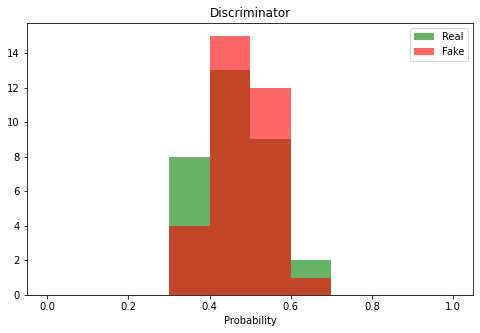

In [33]:
# Before Training
fig = plot_distrib_real_vs_fake(yhat_real, yhat_fake)

An untrained Discriminator cannot distinguish real circles from noise! No surprises...

Let's train it for three epochs and see what happens...

BTW: we're using **two updates** to train the Discriminator. I encourage you to inspect it thoroughly to make sure you're comfortable with full sequence of steps, from the forward passes, to the parameters updates.

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
discriminator.to(device)
generator.to(device)
loss_fn = nn.BCELoss()
optim_d = torch.optim.Adam(discriminator.parameters(), 0.0003)

num_epochs = 3

train_losses_d = []

for epoch in range(1, num_epochs+1):
    batch_losses_d = []
    
    for i, (x_real, _) in enumerate(circles_dl):
        batch_size = x_real.size(0)
        x_real = x_real.to(device)
        
        # trains discriminator
        discriminator.train()
        optim_d.zero_grad()
        # real data
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_real = discriminator(x_real)
        # Step 2 - Computes the loss
        y_real = torch.ones(batch_size, 1, device=device)
        loss_real = loss_fn(yhat_real, y_real)

        # Step 3 - Computes gradients
        loss_real.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_d.step()

        # fake data
        optim_d.zero_grad()
        input_z = latent_sample(batch_size, z_size, 'uniform').to(device)
        x_fake = generator(input_z).detach()
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_fake = discriminator(x_fake)
        # Step 2 - Computes the loss
        y_fake = torch.zeros(batch_size, 1, device=device)
        loss_fake = loss_fn(yhat_fake, y_fake)
        
        # Step 3 - Computes gradients
        loss_fake.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_d.step()

        loss_total = loss_real + loss_fake

        batch_losses_d.append(loss_total.data.item())
                
    # Average over batches
    train_losses_d.append(np.array(batch_losses_d).mean())

    print(f'Epoch {epoch:03d} | Loss >> {train_losses_d[-1]:.4f}')

Epoch 001 | Loss >> 0.1295
Epoch 002 | Loss >> 0.0025
Epoch 003 | Loss >> 0.0014


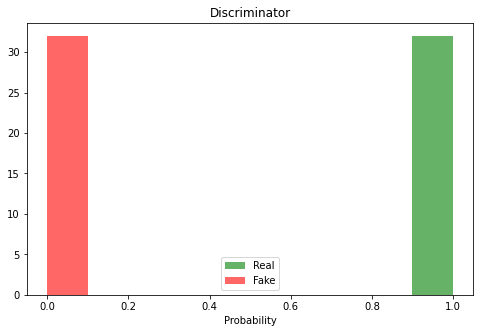

In [35]:
# After training
fig = plot_distrib_real_vs_fake(yhat_real, yhat_fake)

Perfect separation! Our Discriminator is definitely up to the task!

---

Although we **want** our Discriminator to be **strong**, we cannot make it **too strong** (compared to the Generator, that is), otherwise we may end up with **vanishing gradients** and a model that doesn't learn.

---

## Training the Generator

### Mini-Batch of Pretend Data

For the Generator, we use *another* mini-batch of **fake data**, but we'll **pretend they are real**, thus using **1** as their labels.

We'll feed this mini-batch to the Discriminator and compute the loss using BCE as usual, calling it `loss_pretend`.

Just like before, we use the **Generator** to generate fake images from a mini-batch randomly sampled from the latent space. But, **we're not detaching** the fake images since we **need gradients for the Generator**, which we're training at this point.

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/gen_train.png)

### Updating Parameters

Since we only have one loss to handle, this sequence of steps is simpler, but there are still **two differences from a typical training loop**:
- we're not retrieving images from a data loader, but generating them using the model we're training (Generator)
- we're computing the loss using a model we're NOT training (Discriminator), and backpropagating the gradients all the way up to the model we're interested in (Generator)

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/generator_step.png)

### Model Training (GAN)

The training loop for the full GAN will include the three losses above: `loss_real`, `loss_fake`, and `loss_pretend`.

Remember that we need to **train Discriminator and Generator alternately**, so how do we do that?

It's actually simple: we assign **two optimizers**, one for the **Discriminator** part of the GAN model (`gan.discriminator`), the other for the **Generator** part of the GAN model (`gan.generator`).

In [36]:
set_seed(13)
reset_parameters(gan)

gan.to(device)

loss_fn = nn.BCELoss()
# separate optimizers to train them separately
optim_d = torch.optim.SGD(gan.discriminator.parameters(), 0.0002)
optim_g = torch.optim.Adam(gan.generator.parameters(), 0.0002)

Now, notice a small detail, we're using **different optimizers**, namely, **Adam** and **SGD**:

- Adam for the Generator
- SGD for the Discriminator

You're welcome to try using Adam for both, and see the results. In this particular problem, training wasn't going so well. As I said at the start, GANs **may be *finicky*** and difficult to train.

The Adam optimizer is known for its **speed**, it quickly converges to a minimum. It could be that, by using Adam in the Discriminator, it gets too strong too quickly, and the Generator does not stand a chance.

The SGD optimizer, on the other hand, may not be as quick as Adam, but it still goes in the right direction. Apparently, this buys the Generator some time to get better at generating images.

This is actually tip #9 from Soumith Chintala's [GAN Hacks](https://github.com/soumith/ganhacks).

In [38]:
num_epochs = 200

train_losses_d = []
train_losses_d_real = []
train_losses_d_fake = []
train_losses_g = []

epoch_samples = []
fixed_z = latent_sample(5, z_size, 'normal').to(device)

for epoch in range(1, num_epochs+1):
    batch_losses_d = []
    batch_losses_d_real = []
    batch_losses_d_fake = []
    batch_losses_g = []
    
    for i, (x_real, _) in enumerate(circles_dl):
        batch_size = x_real.size(0)
        
        #####################################################
        # Discriminator
        #####################################################
        gan.discriminator.train()
        optim_d.zero_grad()
        
        #####################################################
        # Real data
        #####################################################
        x_real = x_real.to(device)
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_real = gan.discriminator(x_real)

        # Step 2 - Computes the loss
        y_real = torch.ones(batch_size, 1, device=device)
        loss_real = loss_fn(yhat_real, y_real)
        
        # Step 3 - Computes gradients
        loss_real.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_d.step()

        optim_d.zero_grad()
        
        #####################################################
        # Fake data
        #####################################################
        input_z = latent_sample(batch_size, z_size, 'normal').to(device)
        x_fake = gan.generator(input_z).detach()        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_fake = gan.discriminator(x_fake)
        
        # Step 2 - Computes the loss
        y_fake = torch.zeros(batch_size, 1, device=device)
        loss_fake = loss_fn(yhat_fake, y_fake)

        # Step 3 - Computes gradients
        loss_fake.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_d.step()

        loss_total = loss_real + loss_fake
        batch_losses_d_real.append(loss_real.data.item())
        batch_losses_d_fake.append(loss_fake.data.item())
        batch_losses_d.append(loss_total.data.item()/2)
        
        #####################################################
        # Generator
        #####################################################
        gan.generator.train()
        optim_g.zero_grad()
        
        #####################################################
        # Fake/Pretend data
        #####################################################
        input_z = latent_sample(batch_size, z_size, 'normal').to(device)
        x_pretend = gan.generator(input_z) # NO DETACH HERE!
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_pretend = gan.discriminator(x_pretend)

        # Step 2 - Computes the loss
        y_pretend = torch.ones(batch_size, 1, device=device)
        loss_pretend = loss_fn(yhat_pretend, y_pretend)
        
        # Step 3 - Computes gradients
        loss_pretend.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_g.step()
        
        batch_losses_g.append(loss_pretend.data.item())
        
    # Generates some samples from a fixed point in latent space
    # to visualize progress
    x_vis = gan.generator(fixed_z).detach().cpu().numpy()
    epoch_samples.append(x_vis)

    # Average over batches
    train_losses_d.append(np.array(batch_losses_d).mean())
    train_losses_d_real.append(np.array(batch_losses_d_real).mean())
    train_losses_d_fake.append(np.array(batch_losses_d_fake).mean())
    train_losses_g.append(np.array(batch_losses_g).mean())

    print(f'Epoch {epoch:03d} | Loss G/D >> {train_losses_g[-1]:.4f}/{train_losses_d[-1]:.4f} '
          f'Real/Fake >> {train_losses_d_real[-1]:.4f}/{train_losses_d_fake[-1]:.4f}'
         )

Epoch 001 | Loss G/D >> 0.4593/0.8474 Real/Fake >> 0.5831/1.1116
Epoch 002 | Loss G/D >> 0.4942/0.7486 Real/Fake >> 0.4708/1.0263
Epoch 003 | Loss G/D >> 0.5458/0.6794 Real/Fake >> 0.4238/0.9351
Epoch 004 | Loss G/D >> 0.6531/0.5941 Real/Fake >> 0.3898/0.7984
Epoch 005 | Loss G/D >> 0.7706/0.5207 Real/Fake >> 0.3607/0.6808
Epoch 006 | Loss G/D >> 0.8213/0.4900 Real/Fake >> 0.3459/0.6340
Epoch 007 | Loss G/D >> 0.8126/0.4965 Real/Fake >> 0.3525/0.6404
Epoch 008 | Loss G/D >> 0.7728/0.5350 Real/Fake >> 0.3884/0.6816
Epoch 009 | Loss G/D >> 0.5305/0.8336 Real/Fake >> 0.6471/1.0202
Epoch 010 | Loss G/D >> 0.7705/0.7872 Real/Fake >> 0.8538/0.7207
Epoch 011 | Loss G/D >> 0.8238/0.7184 Real/Fake >> 0.7831/0.6537
Epoch 012 | Loss G/D >> 0.8212/0.6784 Real/Fake >> 0.7134/0.6434
Epoch 013 | Loss G/D >> 0.7961/0.6722 Real/Fake >> 0.6810/0.6635
Epoch 014 | Loss G/D >> 0.8115/0.6547 Real/Fake >> 0.6604/0.6490
Epoch 015 | Loss G/D >> 0.8221/0.6363 Real/Fake >> 0.6391/0.6336
Epoch 016 | Loss G/D >> 0

In [37]:
# # Builds dictionary with all elements for resuming training
# checkpoint = {
#   'epoch': epoch,
#   'model_state_dict': gan.state_dict(),
#   'optimizers_state_dict': {
#       'gen': optim_g.state_dict(),
#       'disc': optim_d.state_dict()
#   },
#   'losses': {
#       'gen': train_losses_g, 
#       'disc': {
#           'total': train_losses_d, 
#           'fake': train_losses_d_fake, 
#           'real': train_losses_d_real
#       }
#   },
#   'epoch_samples': epoch_samples
# }
# torch.save(checkpoint, 'first_gan.pth')

In [38]:
checkpoint = torch.load('first_gan.pth')
# Restore state for model and optimizer
gan.load_state_dict(checkpoint['model_state_dict'])
optim_d.load_state_dict(checkpoint['optimizers_state_dict']['disc'])
optim_g.load_state_dict(checkpoint['optimizers_state_dict']['gen'])
epoch = checkpoint['epoch']
train_losses_g = checkpoint['losses']['gen']
train_losses_d = checkpoint['losses']['disc']['total']
train_losses_d_fake = checkpoint['losses']['disc']['fake']
train_losses_d_real = checkpoint['losses']['disc']['real']
epoch_samples = checkpoint['epoch_samples']

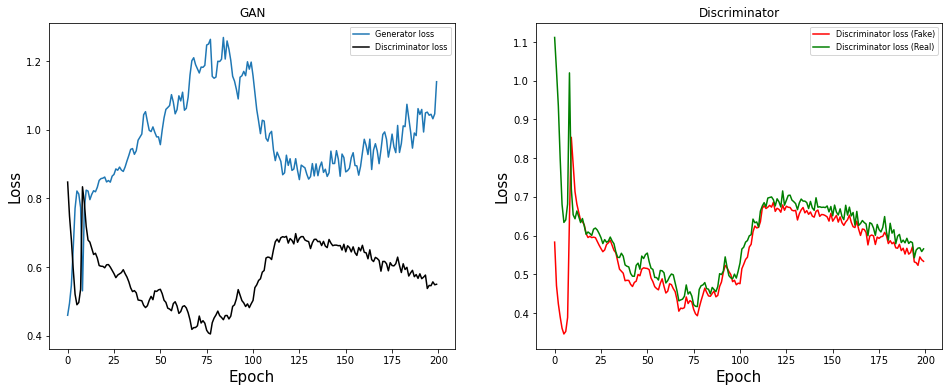

In [39]:
fig = plot_losses(train_losses_g, train_losses_d, train_losses_d_fake, train_losses_d_real)

How do you like the losses above? Doesn't look very good, right?

But that's actually not so bad - remember that the two networks, the Discriminator and the Generator, are in a fierce competition. This means that the **Generator may be producing better images and its loss is still going up** just because the Discriminator got even better! As long as the losses do not oscillate like crazy, your model is probably doing fine.

Also, remember that the Discriminator may learn to pick on *very faint signals* from the fake images, some details that you and I, as humans, cannot even perceive.

So, always check the generated images yourself!

First, let's take a look at 5 points sampled from the latent space, and the corresponding generated images as training goes:

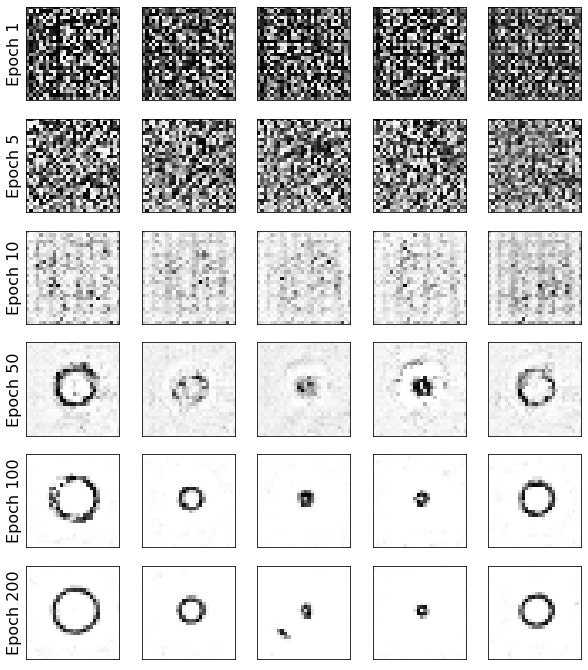

In [40]:
selected_epochs = [1, 5, 10, 50, 100, 200]
fig = plot_evolution(epoch_samples, selected_epochs)

Not bad, right? By the 100th epoch, it was already producing circles!

Let's generate some more random fake images, and plot them next to some real images (the circles we generated at the start using Matplotlib).

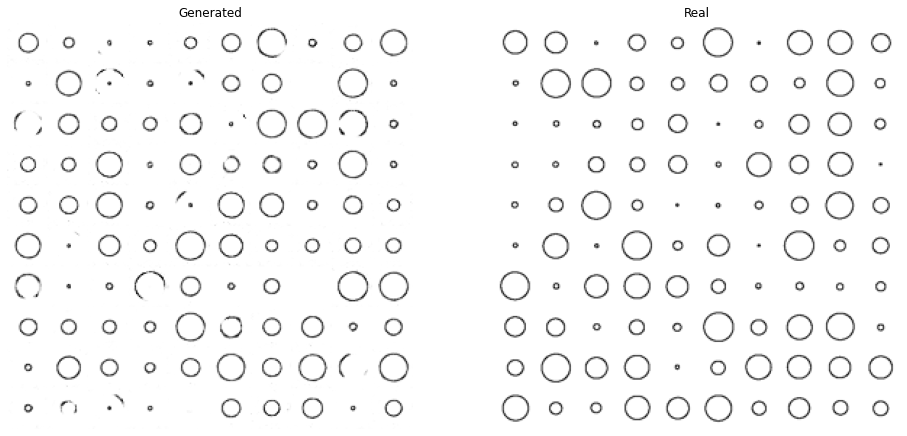

In [41]:
fig = comparison(gan.generator, z_size, circles_dl, device)

Our simple GAN generated many fine circles, and some obviously fake ones.

How is our Discriminator doing?

In [42]:
x_real, _ = next(iter(circles_dl))
x_real = x_real.to(device)
# Step 1 - Computes our model's predicted output - forward pass
yhat_real = gan.discriminator(x_real)

input_z = latent_sample(batch_size, z_size, 'normal').to(device)
x_fake = gan.generator(input_z).detach()
# Step 1 - Computes our model's predicted output - forward pass
yhat_fake = gan.discriminator(x_fake)

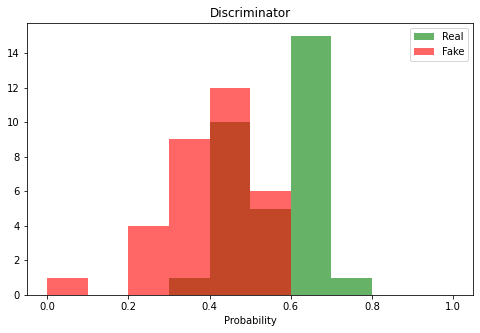

In [43]:
fig = plot_distrib_real_vs_fake(yhat_real, yhat_fake)

It seems the Discriminator can easily tell apart the images.

### Challenges

- Uninformative Loss: Increasing losses are not necessarily bad, as both Discriminator and Generator are competing and improving over time, thus rendering comparison across epochs meaningless.

- Oscillating Loss: Ideally, loss stabilizes or gradually increases or decreases, without oscillating wildly. Plain-vanilla GANs are especially prone to this behavior.

- Mode Collapse: generator finds a "cheat code" that's able to fool the discriminator without generating meaningful images. It may find a single observation (the mode) that consistently fools the discriminator.

## Module 3: Improving your GAN using Wasserstein distance (WGAN and WGAN-GP)

The challenges above can be tackled by changing the loss function: instead of binary cross-entropy, we should use **Wasserstein Distance** (aka [Earth mover's distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)).

We're not delving into the theoretical framework that supports this choice. Instead, we're focusing on its implementation details, and the interpretation of its results.

### Wasserstein Loss

The motivation behind using Wasserstein Loss instead of binary cross-entropy is two-fold:

- the loss is more informative, since it correlates with improvement in Generator's ability to generate quality images.
- the loss is more stable (less oscillations)

It requires the **labels** to be **changed** accordingly:
- `-1` for negative class (fake images)
- `+1` for positive class (real images)

The implementation is actually quite simple: it's the negative average of the product of the **actual label ($y$)** and the **Discriminator's output ($\hat{y}$)**.

$$
\Large \text{Wasserstein Loss} = -\frac{1}{N}\sum_i{\left(\hat{y_i} \ y_i\right)}
$$

$$
\Large \text{Wasserstein Loss} = \begin{cases}
-\frac{1}{N}\sum_i\hat{y_i}, \text{for real data } (y_i = +1)
\\
+\frac{1}{N}\sum_i\hat{y_i}, \text{for fake data } (y_i = -1)
\end{cases}
$$

In [44]:
yhat_fake.mean() - yhat_real.mean()

tensor(-0.1538, device='cuda:0', grad_fn=<SubBackward0>)

If we're using Wasserstein loss, we also need to **remove Discriminator's sigmoid activation**, after all, it was producing probabilities between 0 and 1, and now the **negative class isn't `0` anymore, but `-1`**.

For this reason, the Discriminator is now known as **Critic**, and its output is a **score**, not a probability anymore.

This also means that **losses may be negative**, which may look weird at first sight, but it makes sense if you take your time to look at the possible combinations of labels and outputs from the Discriminator:

$$
\Large (y_i = +1) \text{ and } (\hat{y_i} > 0) \implies \text{loss} < 0
\\
\Large (y_i = -1) \text{ and } (\hat{y_i} < 0) \implies \text{loss} < 0
$$

$$
\Large (y_i = +1) \text{ and } (\hat{y_i} < 0) \implies \text{loss} > 0
\\
\Large (y_i = -1) \text{ and } (\hat{y_i} > 0) \implies \text{loss} > 0
$$

---

**IMPORTANT: If our model is doing well, its loss will be negative!**

---

In [45]:
from typing import Optional
import warnings

def wasserstein_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    size_average: Optional[bool] = None,
    reduce: Optional[bool] = None,
    reduction: str = "mean",
) -> torch.Tensor:
    if torch.overrides.has_torch_function_variadic(input, target):
        return handle_torch_function(
            wasserstein_loss, (input, target), input, target, size_average=size_average, reduce=reduce, reduction=reduction
        )
    if not (target.size() == input.size()):
        warnings.warn(
            "Using a target size ({}) that is different to the input size ({}). "
            "This will likely lead to incorrect results due to broadcasting. "
            "Please ensure they have the same size.".format(target.size(), input.size()),
            stacklevel=2,
        )
    if size_average is not None or reduce is not None:
        reduction = nn._reduction.legacy_get_string(size_average, reduce)

    expanded_input, expanded_target = torch.broadcast_tensors(input, target)
    
    distance = -(expanded_input * expanded_target)
    if reduction == 'none':
        out = distance
    elif reduction == 'mean':
        out = distance.mean()
    elif reduction == 'sum':
        out = distance.sum()
    else:
        raise ValueError("{} is not a valid value for reduction".format(reduction))
        
    return out

class WassersteinLoss(nn.modules.loss._Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(WassersteinLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return wasserstein_loss(input, target, reduction=self.reduction)

### Discriminator (Wasserstein) aka Critic

As mentioned before, the Discriminator/Critic does not have a sigmoid activation anymore, and it outputs a **score** in the range (-inf, +inf).

In [46]:
class DiscriminatorW(nn.Module):
    def __init__(self, input_shape, base_model):
        super().__init__()
        self.input_shape = input_shape
        self.base_model = base_model

        output_size = self._get_output_size()
        # appends the "lin_classifier" linear layer to map from "output_size" 
        # given by the base model to the output of a binary classifier
        output_size = self._get_output_size()
        self.lin_classifier = nn.Linear(output_size, 1)
        # Removing the sigmoid activation
        # self.activation = nn.Sigmoid()
        
    def _get_output_size(self):
        # builds a dummy batch containing one dummy tensor
        # full of zeroes with the same shape as the inputs
        device = next(self.base_model.parameters()).device.type
        dummy = torch.zeros(1, *self.input_shape, device=device)
        # sends the dummy batch through the base model to get 
        # the output size produced by it
        size = self.base_model(dummy).size(1)
        return size
        
    def forward(self, x):
        # forwards the input through the base model and then the "lin_latent" layer 
        # to get the representation (z)
        base_out = self.base_model(x)
        logits = self.lin_classifier(base_out)
        return logits
        # Removing the sigmoid activation
        # out = self.activation(logits)
        # return out

The Discriminator's base model is **almost** the same as before - can you spot the difference?

In [47]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_size = 20
n_filters = 32
in_channels = 1
input_shape = (1, 28, 28)

## No batch norm, no sigmoid!
disc_base = nn.Sequential(
    # in_channels@28x28 -> 32@28x28
    nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters),
    nn.LeakyReLU(0.2),
            
    # 32@28x28 -> 64@14x14
    nn.Conv2d(n_filters, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@14x14 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 3136
    nn.Flatten(),
)

discriminatorW = DiscriminatorW(input_shape, disc_base)

**ANSWER: We replaced `BatchNorm2d` by `InstanceNorm2d`.**

We'll get back to that soon!

## Generator

Once again, we replace `BatchNorm2d` by `InstanceNorm2d`.

In [48]:
generatorW = nn.Sequential(
    # unflatten to generate z_size as pixel
    nn.Unflatten(1, (z_size, 1, 1)),
    
    # z_size@1x1 -> 64@4x4
    nn.ConvTranspose2d(z_size, n_filters*2, kernel_size=4, stride=1, padding=0, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),

    # 64@4x4 -> 64@7x7
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),

    # 64@7x7 -> 32@14x14
    nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters),
    nn.LeakyReLU(0.2),

    # 32@14x14 -> in_channels@28x28
    nn.ConvTranspose2d(n_filters, in_channels, kernel_size=4, stride=2, padding=1),

    nn.Tanh()
)

## WGAN

A GAN that uses a Wasserstein loss is known as WGAN, and it was introduced by Arjovsky, M. et al. in the paper [Wasserstein GAN](https://arxiv.org/abs/1701.07875).

In [49]:
ganW = GAN(generatorW, discriminatorW)

But, changing the loss is not enough. There are more things one needs to take into account to successfully train a WGAN.

a) Replace `BatchNorm` by `InstanceNorm` (that's actually for WGAN-GP, not the original WGAN, but let's jump directly to it).

b) Removing the sigmoid activation from the Discriminator/Critic made it **unconstrained**, since its scores can go from `-inf` to `+inf`. In order to be able to train a WGAN, the Discriminator/Critic needs to **constrained** once again, forcing it to be a so-called *1-Lipschitz continuous function*.

### a) InstanceNorm

The problem with `BatchNorm` is that it creates correlations between data points in the same batch, and it negatively impacts the effectiveness of the **gradient penalty** (we'll get to that soon).

So, we choose `InstanceNorm` instead. It **normalizes individual channels** in sample images (NCHW). For example, in 3-channel 16x16 images (3@16x16), it will compute three pairs of statistics (mean and standard deviation), one pair a channel.

`InstanceNorm` is quite similar to `LayerNorm`, but the latter is often used in **sequence problems**, where there are three-dimensions only (mini-batch, sequence length, number of features). One can use `LayerNorm` to get the *same result* as `InstanceNorm` if one uses the last two dimensions as argument.

Hopefully the diagram and code below makes it more clear. We're using two batches, each batch containing only 2 samples (N=2), each sample being a 3-channel (C=3) 16x16 (H=16, W=16) image.

In [50]:
input_shape = (4, 3, 16, 16) # N C H W
torch.manual_seed(34)
inputs = torch.randn(*input_shape)
batches = inputs.split(2)
batches[0].shape

torch.Size([2, 3, 16, 16])

![](https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/images/instance_norm.png)

In [51]:
inst_normalized = nn.InstanceNorm2d(3)(batches[0])
inst_normalized.mean(axis=[2, 3]), inst_normalized.var(axis=[2, 3], unbiased=False)

(tensor([[-1.3039e-08,  2.0489e-08, -3.7253e-09],
         [-1.0710e-08, -9.3132e-09, -3.7253e-09]]),
 tensor([[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]]))

Two samples in a batch, three channels in a sample, so there are 6 pairs of statistics.

### b) 1-Lipschitz Continuous Function

That's a mouthful, right? Let's see, and visualize, what a function has to look like to be a *1-Lipschitz Continuous Function*.

$$
\Large \frac{\lvert f(x_1) - f(x_2) \rvert}{\lvert x_1 - x_2 \rvert} \leq k \implies \frac{\lvert\Delta{y}\rvert}{\lvert\Delta{x}\rvert} \leq k
$$

For every pair of $x$ values, we divide the (absolute) change in $y$ by the (absolute) change in $x$.

If **all** results are less than or equal to a given $k$, the function is said to be *k-Lipschitz*.

Let's look at some examples for ***k*=1**.

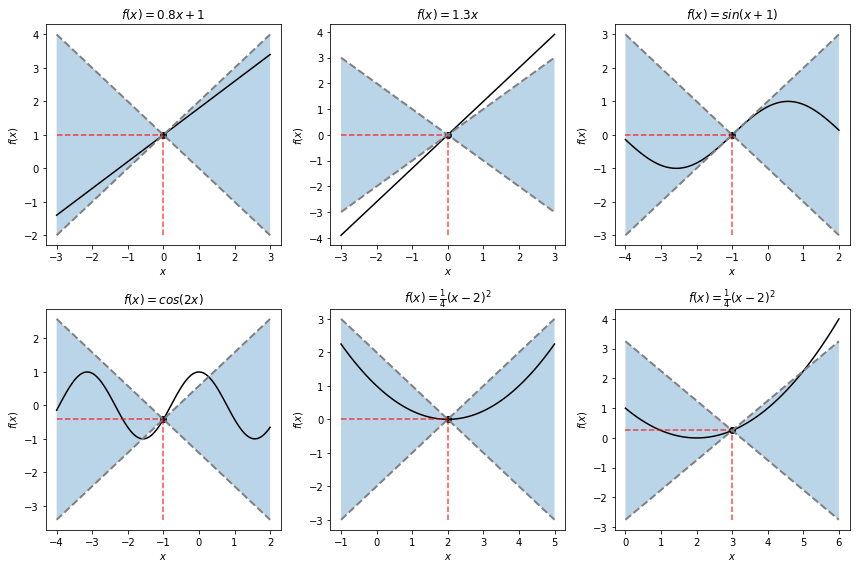

In [52]:
x = np.linspace(-3, 3, 101)
fs = [make_f(.8, 1.), make_f(1.3, 0.), lambda x: np.sin(x+1), lambda x: np.cos(2*x), lambda x: (x-2)**2/4, lambda x: (x-2)**2/4]
x0s = [0, 0, -1, -1, 2, 3]
titles = [r'$f(x)=0.8x+1$', r'$f(x)=1.3x$', r'$f(x)=sin(x+1)$', r'$f(x)=cos(2x)$', r'$f(x)=\frac{1}{4}(x-2)^2$', r'$f(x)=\frac{1}{4}(x-2)^2$']
k = 1

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    lipschitz(x, fs[i], x0s[i], titles[i], k, ax)

In the plots above, only the *first* and *third* plots of the first row are 1-Lipschitz.

They are the only ones where **the function lies completely inside the blue region**, regardless of the starting point.

#### 1-Lipschitz Discriminator/Critic

In our case, the **function** is the whole neural network used as **Discriminator/Critic**, and D($x$) is the **score** it outputs.

The inputs ($x$) are, in our case, the **images**, both fake and real, and $x_1 - x_2$ is the average absolute difference between two images, pixelwise.

$$
\Large \frac{\lvert D(x_1) - D(x_2) \rvert}{\lvert x_1 - x_2 \rvert} \leq 1
$$

So, for the Discriminator to be a k-Lipschitz Continous Function, the **norm of the gradients of its scores w.r.t to the pixels in the images must be at most *k***.

For WGANs to work, the authors of the paper show it is required that ***k*=1**.

#### How To Enforce the 1-Lipschitz-ness?

1. **Weight Clipping** using a small range [-0.01, 0.01] as proposed by the authors of the WGAN paper.
 - *“Weight clipping is a clearly terrible way to enforce a Lipschitz constraint.”*
 - It weakens the Critic.
 - We need a strong Critic to push the Generator to learn how to produce good samples.
 - It can lead to exploding or vanishing gradients.
 

2. **Gradient Penalty (GP)**, including a new term in the loss function.

### Gradient Penalty

The idea of including a gradient penalty term to the loss was introduced in the paper ["Improved Training of Wasserstein GANs"](https://arxiv.org/abs/1704.00028) by Gulrajani, I. et al.

We already know that, for the Discriminator/Critic to be a 1-Lipschitz function, the norm of the gradients of its scores w.r.t. the input images must be at most one.

So, why not include a new term in the loss that **penalizes** the model if the **norm of the gradients deviates from 1**?

This way, minimizing the loss, that is, *training* the model, will naturally push the model to conform to the 1-Lipschitz constraint.

This new term is defined as the **mean squared error** between the **norm of the gradients** and the **desired norm, one**.

$$
\Large
\text{GP} = \lambda \frac{1}{N}\sum_{i=0}^N \left( \| \nabla_i \|_2-1 \right)^2
$$

On top of that, it also includes a **multiplying factor** (`lambda_gp`), usually 10.

Now the question is, which images should one use to compute the norm of the gradients above?

#### Computing Gradients

We have some real images, and an infinite supply of fake images (after all, we can keep the Generator producing them as long as we want).

We cannot obviously use the *whole latent space*, so we settle for a handful of points only.

Better yet, we settle for some **images in between real and fake**, that is, **interpolated**.

It goes like this:
1. For each pair of fake and real samples in a given batch, we **choose a random number (`alpha`) between 0 and 1**
2. Then we **interpolate between the two images**, pixelwise, using `alpha`
3. We feed the interpolated image to the Critic and **get the corresponding score**
4. Next, we **compute the gradients of the score w.r.t to the interpolated image** (each pixel has a gradient)
5. We take the **l2-norm of the gradients**, so there's one value for each interpolated image
6. Then we **compute the MSE**, assuming we want every norm to be as close to 1 as possible, and **apply the multiplying factor `lambda_gp`**

Let's go over the steps above for a mini-batch of five real, and five fake, images:

In [53]:
set_seed(13)
latent = latent_sample(5, z_size, 'uniform').to(device)
fake_samples = generatorW.to(device)(latent).detach().cpu()
real_samples = next(iter(circles_dl))[0][:5]
fake_samples.shape, real_samples.shape

(torch.Size([5, 1, 28, 28]), torch.Size([5, 1, 28, 28]))

#### 1. Choose a random number (`alpha`)

In [54]:
alpha = torch.rand(5, 1, 1, 1, requires_grad=True)
alpha.shape, alpha

(torch.Size([5, 1, 1, 1]),
 tensor([[[[0.9947]]],
 
 
         [[[0.2882]]],
 
 
         [[[0.8013]]],
 
 
         [[[0.6001]]],
 
 
         [[[0.6325]]]], requires_grad=True))

#### 2. Interpolate between fake and real images

In [55]:
interpolated = alpha * real_samples + (1 - alpha) * fake_samples
interpolated.shape

torch.Size([5, 1, 28, 28])

#### 3. Get Critic's scores

In [56]:
score_interpolated = discriminatorW.to(device)(interpolated.to(device))
score_interpolated

tensor([[-0.1222],
        [ 0.3358],
        [ 0.3103],
        [ 0.0647],
        [ 0.4415]], device='cuda:0', grad_fn=<AddmmBackward>)

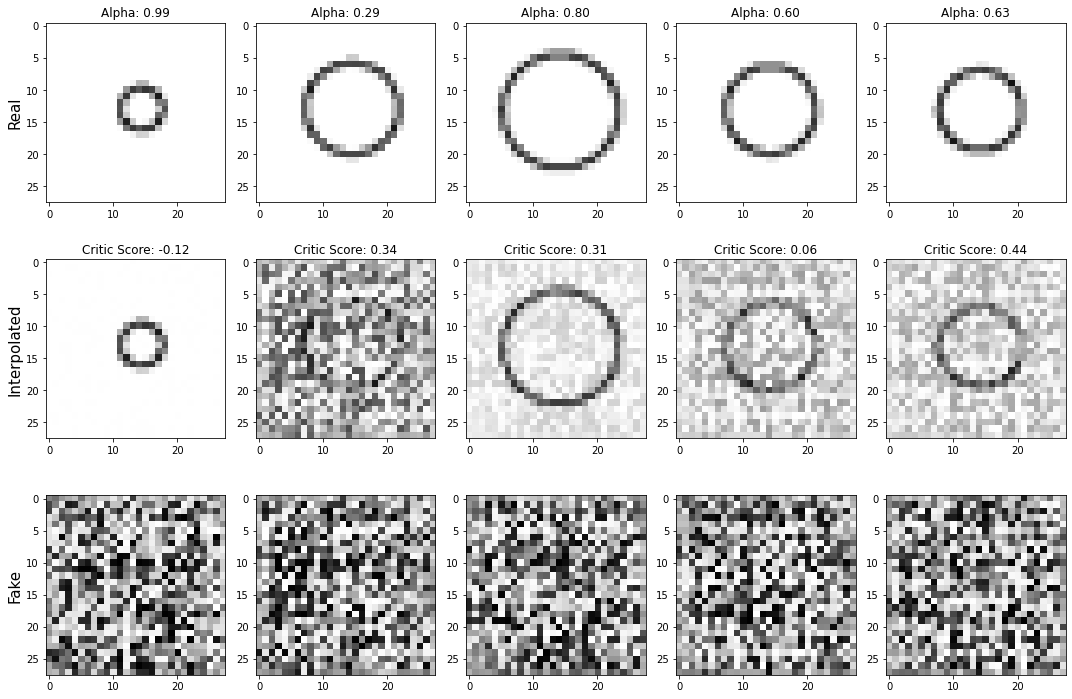

In [57]:
fig = plot_interpolated(z_size, ganW, circles_dl)

#### 4. Compute the gradients of the score w.r.t. interpolated image

In [58]:
from torch.autograd import grad as torch_grad

gradients = torch_grad(
    outputs=score_interpolated, inputs=interpolated,
    grad_outputs=torch.ones(score_interpolated.size(), device=device),
    create_graph=True, retain_graph=True
)[0]

gradients.shape, gradients.min(), gradients.max()

(torch.Size([5, 1, 28, 28]),
 tensor(-0.2759, grad_fn=<MinBackward1>),
 tensor(0.2718, grad_fn=<MaxBackward1>))

#### 5. Take l2-norm of the gradients

In [59]:
# Manually
norms = (gradients**2).sum(dim=[1, 2, 3]).sqrt()
norms

tensor([1.8060, 1.3414, 1.5683, 1.7121, 1.7966], grad_fn=<SqrtBackward>)

In [60]:
# Using norm method
grad_norm = gradients.view(5, -1).norm(2, dim=1)
grad_norm

tensor([1.8060, 1.3414, 1.5683, 1.7121, 1.7966], grad_fn=<NormBackward1>)

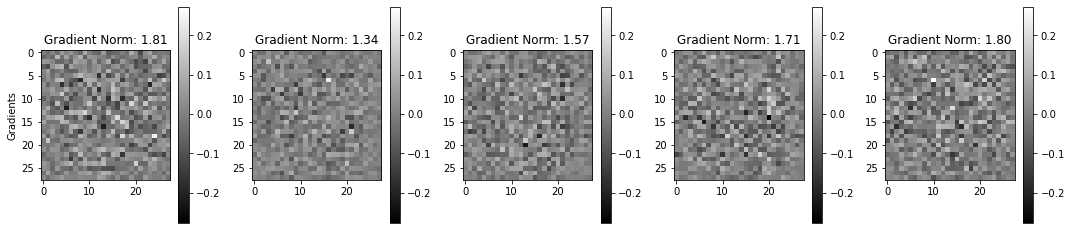

In [61]:
fig = pixel_gradients(gradients)

#### 6. Compute MSE and apply lambda factor

In [62]:
lambda_gp = 10
penalty = lambda_gp * ((1-grad_norm)**2).mean()
penalty

tensor(4.4617, grad_fn=<MulBackward0>)

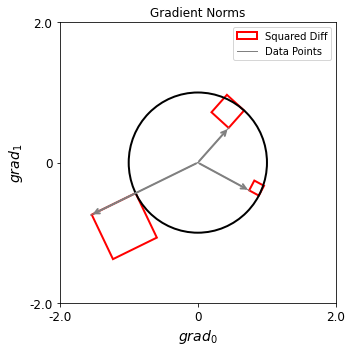

In [63]:
grads = torch.tensor([[.45, .5], 
                  [.75, -.4], 
                  [-1.55, -.75]]).view(3, 2) # N, L, H
fig = grad_norms(grads)

#### Gradient Penalty Function

In [64]:
def gradient_penalty(discriminator, x_real, x_fake, lambda_gp=10):
    batch_size = x_real.size(0)
    # random alpha between 0 and 1 for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1, requires_grad=True).type_as(x_real)

    # interpolated samples
    interpolated = alpha * x_real + (1 - alpha) * x_fake
    # critic score for each sample
    prob_interpolated = discriminator(interpolated)

    # how much the score changes if the sample is modified?
    # large gradients mean the critic is oversensitive
    gradients = torch_grad(
        outputs=prob_interpolated, inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size()).type_as(x_real),
        create_graph=True, retain_graph=True
    )[0].view(batch_size, -1)

    grad_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((grad_norm-1)**2).mean() 

### Model Training (WGAN-GP)

The training loop of a WGAN-GP is **almost** the same as our former training loops, except for a few differences:

- before, we were concerned about keeping Discriminator and Generator balanced, but WGANs are different - we **should** train the Critic/Discriminator to convergence, so the gradients for the Generator are more accurate - so we **train the Critic SEVERAL times** (usually 5 iterations) before **training the Generator once**.
- instead of using *two updates* (one for real loss, one for fake loss) for the Critic/Discriminator, we're now using a **single update** using the **total loss** (real, fake, and GP)

In [65]:
ganW.to(device)

loss_fn = WassersteinLoss()

optim_d = torch.optim.SGD(ganW.discriminator.parameters(), 0.0002)
optim_g = torch.optim.Adam(ganW.generator.parameters(), 0.0002)

In [73]:
num_epochs = 50

train_losses_d = []
train_losses_d_real = []
train_losses_d_fake = []
train_losses_d_penalty = []
train_losses_g = []

critic_iterations = 5

fixed_z = latent_sample(5, z_size, 'normal').to(device)
epoch_samples = []

for epoch in range(1, num_epochs+1):
    batch_losses_d = []
    batch_losses_d_real = []
    batch_losses_d_fake = []
    batch_losses_d_penalty = []
    batch_losses_g = []
    
    for i, (x_real, _) in enumerate(circles_dl):
        batch_size = x_real.size(0)
        
        for i in range(critic_iterations):
            #####################################################
            # Critic
            #####################################################
            ganW.discriminator.train()
            optim_d.zero_grad()
            
            #####################################################
            # Real data
            #####################################################
            x_real = x_real.to(device)
            y_real = torch.ones(batch_size, 1, device=device)
            # Step 1 - Computes our model's predicted output - forward pass
            yhat_real = ganW.discriminator(x_real)
            # Step 2 - Computes the loss
            loss_real = loss_fn(yhat_real, y_real)

            #####################################################
            # Fake data
            #####################################################
            input_z = latent_sample(batch_size, z_size, 'normal').to(device)
            x_fake = ganW.generator(input_z).detach()
            y_fake = -torch.ones(batch_size, 1, device=device)
            # Step 1 - Computes our model's predicted output - forward pass
            yhat_fake = ganW.discriminator(x_fake)
            # Step 2 - Computes the loss
            loss_fake = loss_fn(yhat_fake, y_fake)

            #####################################################
            # Gradient Penalty
            #####################################################            
            loss_penalty = gradient_penalty(ganW.discriminator, x_real.data, x_fake.data)

            loss_total = loss_real + loss_fake + loss_penalty
            # Step 3 - Computes gradients
            loss_total.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            optim_d.step()
        
        batch_losses_d_real.append(loss_real.data.item())
        batch_losses_d_fake.append(loss_fake.data.item())
        batch_losses_d_penalty.append(loss_penalty.data.item())
        batch_losses_d.append((loss_real + loss_fake).data.item()/2)
        
        #####################################################
        # Generator
        #####################################################
        ganW.generator.train()
        optim_g.zero_grad()
        
        #####################################################
        # Fake/Pretend data
        #####################################################        
        input_z = latent_sample(batch_size, z_size, 'normal').to(device)
        y_pretend = torch.ones(batch_size, 1, device=device)
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_pretend = ganW(input_z)
        # Step 2 - Computes the loss
        loss_pretend = loss_fn(yhat_pretend, y_pretend)
        
        # Step 3 - Computes gradients
        loss_pretend.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_g.step()
        
        batch_losses_g.append(loss_pretend.data.item())

    # Average over batches
    train_losses_d.append(np.array(batch_losses_d).mean())
    train_losses_d_real.append(np.array(batch_losses_d_real).mean())
    train_losses_d_fake.append(np.array(batch_losses_d_fake).mean())
    train_losses_d_penalty.append(np.array(batch_losses_d_penalty).mean())
    train_losses_g.append(np.array(batch_losses_g).mean())
    
    # Generates some samples from a fixed point in latent space
    # to visualize progress
    x_vis = ganW.generator(fixed_z).detach().cpu().numpy()
    epoch_samples.append(x_vis)    

    print(f'Epoch {epoch:03d} | Loss G/D >> {train_losses_g[-1]:.4f}/{train_losses_d[-1]:.4f} '
          f'Real/Fake/Penalty >> {train_losses_d_real[-1]:.4f}/{train_losses_d_fake[-1]:.4f}/{train_losses_d_penalty[-1]:.4f}'
         )

Epoch 001 | Loss G/D >> 0.5618/-2.0389 Real/Fake/Penalty >> -3.5506/-0.5273/0.6375
Epoch 002 | Loss G/D >> 2.9998/-6.7343 Real/Fake/Penalty >> -10.5495/-2.9191/1.9784
Epoch 003 | Loss G/D >> -0.6339/-6.5623 Real/Fake/Penalty >> -13.7834/0.6588/2.5100
Epoch 004 | Loss G/D >> -6.3921/-1.7117 Real/Fake/Penalty >> -9.8766/6.4533/0.5520
Epoch 005 | Loss G/D >> -4.0875/-1.8651 Real/Fake/Penalty >> -7.8353/4.1052/0.3265
Epoch 006 | Loss G/D >> -4.6950/-1.6563 Real/Fake/Penalty >> -8.0378/4.7252/0.2813
Epoch 007 | Loss G/D >> -3.5993/-1.9736 Real/Fake/Penalty >> -7.6261/3.6788/0.3168
Epoch 008 | Loss G/D >> -3.6097/-1.9985 Real/Fake/Penalty >> -7.6481/3.6511/0.3376
Epoch 009 | Loss G/D >> -3.0556/-2.2715 Real/Fake/Penalty >> -7.5985/3.0554/0.4111
Epoch 010 | Loss G/D >> -2.9820/-2.2447 Real/Fake/Penalty >> -7.4931/3.0036/0.4013
Epoch 011 | Loss G/D >> -2.9158/-2.2164 Real/Fake/Penalty >> -7.3442/2.9113/0.4096
Epoch 012 | Loss G/D >> -2.9735/-2.1655 Real/Fake/Penalty >> -7.2764/2.9454/0.4048
Ep

In [66]:
# # Builds dictionary with all elements for resuming training
# checkpoint = {
#   'epoch': epoch,
#   'model_state_dict': ganW.state_dict(),
#   'optimizers_state_dict': {
#       'gen': optim_g.state_dict(),
#       'disc': optim_d.state_dict()
#   },
#   'losses': {
#       'gen': train_losses_g, 
#       'disc': {
#           'total': train_losses_d, 
#           'fake': train_losses_d_fake, 
#           'real': train_losses_d_real,
#           'penalty': train_losses_d_penalty
#       }
#   },
#   'epoch_samples': epoch_samples
# }
# torch.save(checkpoint, 'ganW.pth')

In [67]:
checkpoint = torch.load('ganW.pth')
# Restore state for model and optimizer
ganW.load_state_dict(checkpoint['model_state_dict'])
optim_d.load_state_dict(checkpoint['optimizers_state_dict']['disc'])
optim_g.load_state_dict(checkpoint['optimizers_state_dict']['gen'])
epoch = checkpoint['epoch']
train_losses_g = checkpoint['losses']['gen']
train_losses_d = checkpoint['losses']['disc']['total']
train_losses_d_fake = checkpoint['losses']['disc']['fake']
train_losses_d_real = checkpoint['losses']['disc']['real']
train_losses_d_penalty = checkpoint['losses']['disc']['penalty']
epoch_samples = checkpoint['epoch_samples']

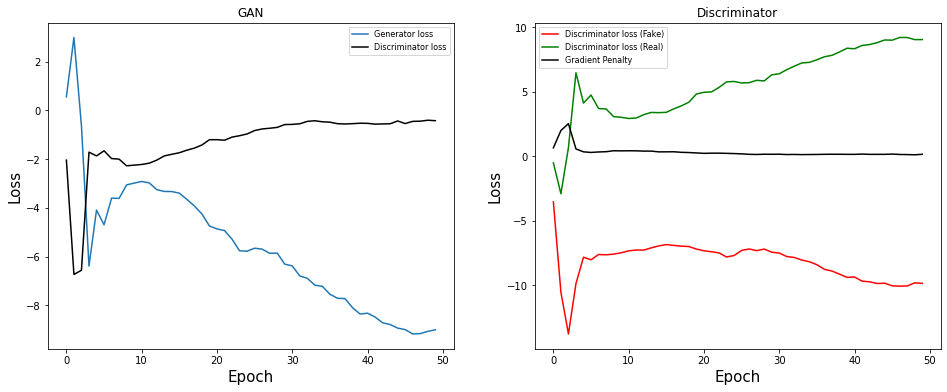

In [68]:
fig = plot_losses(train_losses_g, train_losses_d, train_losses_d_fake, train_losses_d_real, train_losses_d_penalty)

Clearly, the losses are more stable now. The gradient penalty is quite close to zero, meaning the Critic/Discriminator was successfully constrained as a 1-Lipschitz function.

How about the actual generated images?

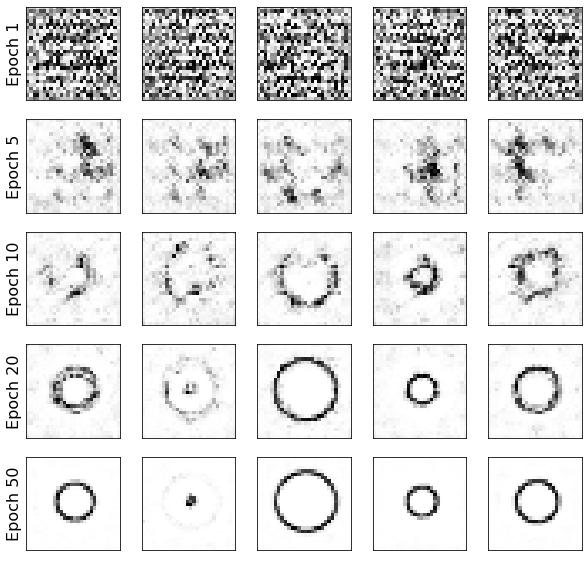

In [69]:
selected_epochs = [1, 5, 10, 20, 50]
fig = plot_evolution(epoch_samples, selected_epochs)

Not bad, right?

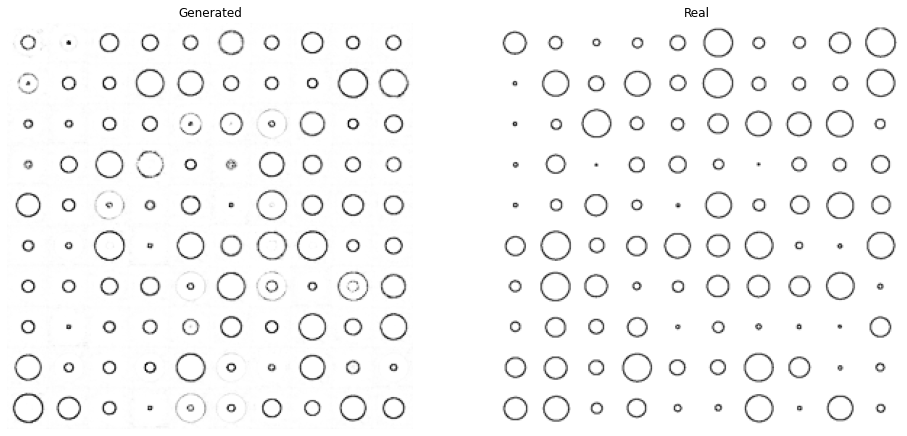

In [70]:
fig = comparison(ganW.generator, z_size, circles_dl, device)

In [71]:
x_real, _ = next(iter(circles_dl))
x_real = x_real.to(device)
# Step 1 - Computes our model's predicted output - forward pass
yhat_real = ganW.discriminator(x_real)

input_z = latent_sample(batch_size, z_size, 'normal').to(device)
x_fake = ganW.generator(input_z).detach()
# Step 1 - Computes our model's predicted output - forward pass
yhat_fake = ganW.discriminator(x_fake)

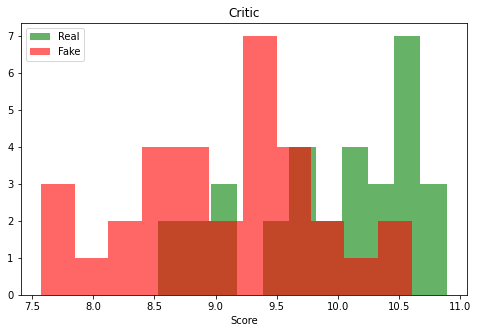

In [72]:
fig = plot_distrib_real_vs_fake(yhat_real, yhat_fake, is_critic=True)

We see some intersection in the histogram above, so the Critic/Discriminator sometimes can't tell the difference between a fake and a real image!

## Wrapping Up: GANs N' Roses

It's time to generate some synthetic roses!

We've finally arrived at the part that inspired the name of this workshop :-)

We'll be using a subset of [VGG's 102 Category Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

It's kinda frustrating that the actual labels are not there, and I can't identify many flowers myself, but luckily someone else ran into this problem and figured out the labels: https://github.com/bdevnani3/oxfordflowers102-label-name-mapping/blob/main/mapping.json

Assuming those labels are correct, I got category 74 (rose), and tried to split it into different colors (orange, red, rose, white, and yellow), but we're not actually using these sub-labels in this example.

In [74]:
#!curl https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -o 102flowers.tgz

In [75]:
import os
import tarfile
import pandas as pd

def extract_flowers(dataset, fnames, outdir):
    df = pd.read_csv(fnames)
    
    for category in df.category.unique():
        if not os.path.exists(f'{outdir}/{category}'):
            os.makedirs(f'{outdir}/{category}')

    t = tarfile.open(dataset, 'r')
    
    for member in t.getmembers():
        match = (df.fname == member.name[4:])
        if match.any():
            fname, category = df.loc[match.idxmax()]
            t._extract_member(member, f"{outdir}/{category}/{fname}", set_attrs=True, numeric_owner=False)    

In [84]:
!curl https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/gans.py --output gans.py
!curl https://raw.githubusercontent.com/dvgodoy/GANsNRoses_Geekle_DS_Summit22/main/roses.csv --output roses.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11267  100 11267    0     0  84082      0 --:--:-- --:--:-- --:--:-- 84082
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3706  100  3706    0     0  27656      0 --:--:-- --:--:-- --:--:-- 27656


In [76]:
outdir = 'flowers/roses'
dataset = '102flowers.tgz'
fnames = 'roses.csv'
extract_flowers(dataset, fnames, outdir)

In [77]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize

flowers_ds = ImageFolder(root='flowers/roses', transform=Compose([CenterCrop(500), Resize(28), ToTensor(), Normalize(mean=(0.5), std=(0.5))]))
flowers_dl = DataLoader(flowers_ds, batch_size=32, shuffle=True, drop_last=True)

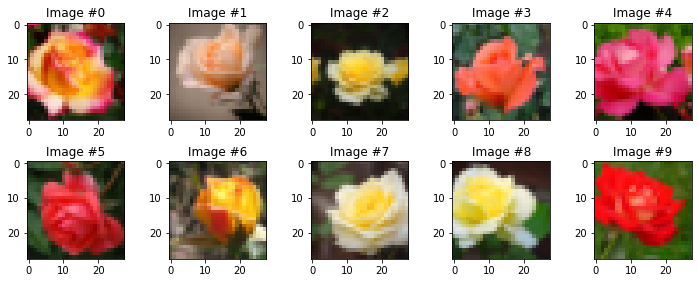

In [78]:
fig = preview(flowers_dl)

### WGAN-GP

We're using the same models as before, but the size of the latent space is 40 now, since our images are more complex than circles.

Moreover, we're using `Dropout` layers in the Generator, that's tip #17 from Soumith Chintala's [GAN Hacks](https://github.com/soumith/ganhacks).

Adding dropout actually **increased variability** of the generated samples **by a lot**! I encourage you to try removing those layers (or setting the probability to zero), retrain the model, and see the difference yourself.

In [79]:
set_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_size = 40
n_filters = 32
# color images = 3 channels
in_channels = 3
input_shape = (3, 28, 28)

disc_base = nn.Sequential(
    # in_channels@28x28 -> 32@28x28
    nn.Conv2d(in_channels, n_filters, kernel_size=3, stride=1, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters),
    nn.LeakyReLU(0.2),
            
    # 32@28x28 -> 64@14x14
    nn.Conv2d(n_filters, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@14x14 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 64@7x7
    nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, stride=1, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.LeakyReLU(0.2),
    
    # 64@7x7 -> 3136
    nn.Flatten(),
)

# discriminator is the same as our former encoder, but it outputs probabilities now
discriminatorW = DiscriminatorW(input_shape, disc_base)

generatorW = nn.Sequential(
    # unflatten to generate z_size as pixel
    nn.Unflatten(1, (z_size, 1, 1)),
    
    # z_size@1x1 -> 64@4x4
    nn.ConvTranspose2d(z_size, n_filters*2, kernel_size=4, stride=1, padding=0, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.Dropout2d(0.5),
    nn.LeakyReLU(0.2),

    # 64@4x4 -> 64@7x7
    nn.ConvTranspose2d(n_filters*2, n_filters*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters*2),
    nn.Dropout2d(0.5),
    nn.LeakyReLU(0.2),

    # 64@7x7 -> 32@14x14
    nn.ConvTranspose2d(n_filters*2, n_filters, kernel_size=4, stride=2, padding=1, bias=False),
    nn.InstanceNorm2d(n_filters),
    nn.Dropout2d(0.5),
    nn.LeakyReLU(0.2),

    # 32@14x14 -> in_channels@28x28
    nn.ConvTranspose2d(n_filters, in_channels, kernel_size=4, stride=2, padding=1),

    nn.Tanh()
)

ganW = GAN(generatorW, discriminatorW)

In [80]:
ganW.to(device)

loss_fn = WassersteinLoss()

optim_d = torch.optim.SGD(ganW.discriminator.parameters(), 0.0003)
optim_g = torch.optim.Adam(ganW.generator.parameters(), 0.0003)

In [89]:
num_epochs = 200

train_losses_d = []
train_losses_d_real = []
train_losses_d_fake = []
train_losses_d_penalty = []
train_losses_g = []

critic_iterations = 5

fixed_z = latent_sample(5, z_size, 'normal').to(device)
epoch_samples = []

for epoch in range(1, num_epochs+1):
    batch_losses_d = []
    batch_losses_d_real = []
    batch_losses_d_fake = []
    batch_losses_d_penalty = []
    batch_losses_g = []
    
    for i, (x_real, _) in enumerate(flowers_dl):
        batch_size = x_real.size(0)
        
        for i in range(critic_iterations):
            #####################################################
            # Critic
            #####################################################
            ganW.discriminator.train()
            optim_d.zero_grad()

            #####################################################
            # Real data
            #####################################################            
            x_real = x_real.to(device)
            y_real = torch.ones(batch_size, 1, device=device)
            # Step 1 - Computes our model's predicted output - forward pass
            yhat_real = ganW.discriminator(x_real)
            # Step 2 - Computes the loss
            loss_real = loss_fn(yhat_real, y_real)

            #####################################################
            # Fake data
            #####################################################
            input_z = latent_sample(batch_size, z_size, 'normal').to(device)
            x_fake = ganW.generator(input_z).detach()
            y_fake = -torch.ones(batch_size, 1, device=device)
            # Step 1 - Computes our model's predicted output - forward pass
            yhat_fake = ganW.discriminator(x_fake)
            # Step 2 - Computes the loss
            loss_fake = loss_fn(yhat_fake, y_fake)

            #####################################################
            # Gradient Penalty
            #####################################################
            loss_penalty = gradient_penalty(ganW.discriminator, x_real.data, x_fake.data)

            loss_total = loss_real + loss_fake + loss_penalty
            # Step 3 - Computes gradients
            loss_total.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            optim_d.step()
        
        batch_losses_d_real.append(loss_real.data.item())
        batch_losses_d_fake.append(loss_fake.data.item())
        batch_losses_d_penalty.append(loss_penalty.data.item())
        batch_losses_d.append((loss_real + loss_fake).data.item()/2)
        
        #####################################################
        # Generator
        #####################################################
        ganW.generator.train()
        optim_g.zero_grad()
        
        #####################################################
        # Fake/Pretend data
        #####################################################        
        input_z = latent_sample(batch_size, z_size, 'normal').to(device)
        y_pretend = torch.ones(batch_size, 1, device=device)
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat_pretend = ganW(input_z)
        # Step 2 - Computes the loss
        loss_pretend = loss_fn(yhat_pretend, y_pretend)
        
        # Step 3 - Computes gradients
        loss_pretend.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optim_g.step()
        
        batch_losses_g.append(loss_pretend.data.item())

    # Average over batches
    train_losses_d.append(np.array(batch_losses_d).mean())
    train_losses_d_real.append(np.array(batch_losses_d_real).mean())
    train_losses_d_fake.append(np.array(batch_losses_d_fake).mean())
    train_losses_d_penalty.append(np.array(batch_losses_d_penalty).mean())
    train_losses_g.append(np.array(batch_losses_g).mean())

    # Generates some samples from a fixed point in latent space
    # to visualize progress
    x_vis = ganW.generator(fixed_z).detach().cpu().numpy()
    epoch_samples.append(x_vis)    
    
    print(f'Epoch {epoch:03d} | Loss G/D >> {train_losses_g[-1]:.4f}/{train_losses_d[-1]:.4f} '
          f'Real/Fake/Penalty >> {train_losses_d_real[-1]:.4f}/{train_losses_d_fake[-1]:.4f}/{train_losses_d_penalty[-1]:.4f}'
         )

Epoch 001 | Loss G/D >> 0.1571/-0.4076 Real/Fake/Penalty >> -0.6788/-0.1365/1.2861
Epoch 002 | Loss G/D >> 0.2993/-1.2823 Real/Fake/Penalty >> -2.2464/-0.3181/0.3659
Epoch 003 | Loss G/D >> 0.4357/-2.0883 Real/Fake/Penalty >> -3.7145/-0.4622/0.5531
Epoch 004 | Loss G/D >> 0.4044/-2.5214 Real/Fake/Penalty >> -4.6900/-0.3529/0.5920
Epoch 005 | Loss G/D >> 0.2109/-2.7268 Real/Fake/Penalty >> -5.2985/-0.1550/0.8094
Epoch 006 | Loss G/D >> 0.1547/-2.8396 Real/Fake/Penalty >> -5.5888/-0.0904/0.6583
Epoch 007 | Loss G/D >> 0.0249/-3.0028 Real/Fake/Penalty >> -5.9636/-0.0419/0.7213
Epoch 008 | Loss G/D >> 0.1494/-3.0126 Real/Fake/Penalty >> -5.9888/-0.0364/0.8291
Epoch 009 | Loss G/D >> 0.1650/-3.2280 Real/Fake/Penalty >> -6.2270/-0.2291/0.9365
Epoch 010 | Loss G/D >> 0.2991/-3.1952 Real/Fake/Penalty >> -6.1877/-0.2026/0.8174
Epoch 011 | Loss G/D >> 0.5574/-3.4440 Real/Fake/Penalty >> -6.4683/-0.4198/0.6962
Epoch 012 | Loss G/D >> 0.8755/-3.5792 Real/Fake/Penalty >> -6.4130/-0.7453/0.8373
Epoc

In [81]:
# # Builds dictionary with all elements for resuming training
# checkpoint = {
#   'epoch': epoch,
#   'model_state_dict': ganW.state_dict(),
#   'optimizers_state_dict': {
#       'gen': optim_g.state_dict(),
#       'disc': optim_d.state_dict()
#   },
#   'losses': {
#       'gen': train_losses_g, 
#       'disc': {
#           'total': train_losses_d, 
#           'fake': train_losses_d_fake, 
#           'real': train_losses_d_real,
#           'penalty': train_losses_d_penalty
#       }
#   },
#   'epoch_samples': epoch_samples
# }
# torch.save(checkpoint, 'gans_n_roses.pth')

In [82]:
checkpoint = torch.load('gans_n_roses.pth')
# Restore state for model and optimizer
ganW.load_state_dict(checkpoint['model_state_dict'])
optim_d.load_state_dict(checkpoint['optimizers_state_dict']['disc'])
optim_g.load_state_dict(checkpoint['optimizers_state_dict']['gen'])
epoch = checkpoint['epoch']
train_losses_g = checkpoint['losses']['gen']
train_losses_d = checkpoint['losses']['disc']['total']
train_losses_d_fake = checkpoint['losses']['disc']['fake']
train_losses_d_real = checkpoint['losses']['disc']['real']
train_losses_d_penalty = checkpoint['losses']['disc']['penalty']
epoch_samples = checkpoint['epoch_samples']

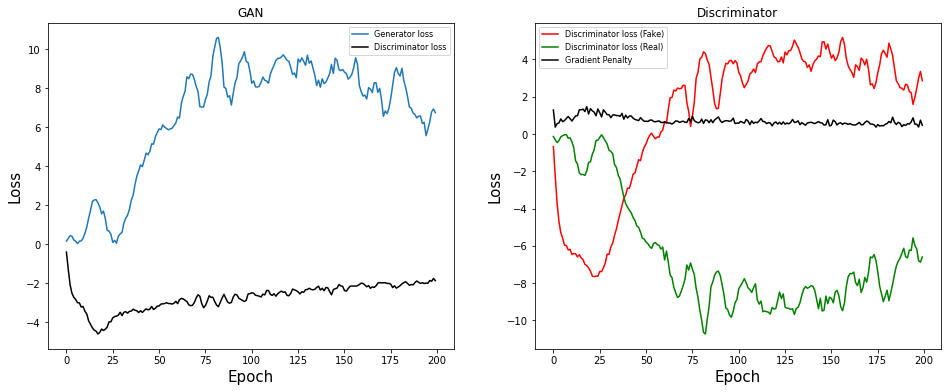

In [83]:
fig = plot_losses(train_losses_g, train_losses_d, train_losses_d_fake, train_losses_d_real, train_losses_d_penalty)

A little bit more oscillation now, but overall still stable.

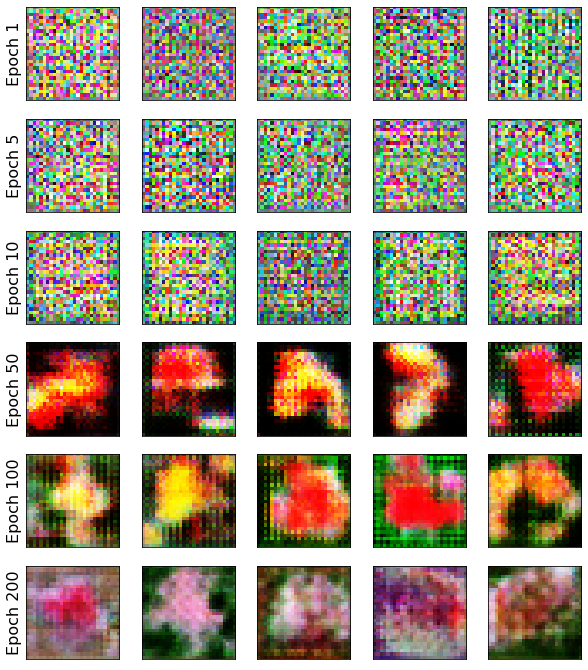

In [84]:
selected_epochs = [1, 5, 10, 50, 100, 200]
fig = plot_evolution(epoch_samples, selected_epochs)

Looks like we got some generated flowers indeed :-)

Let's take a look at a larger selection, and compare them to the real images:

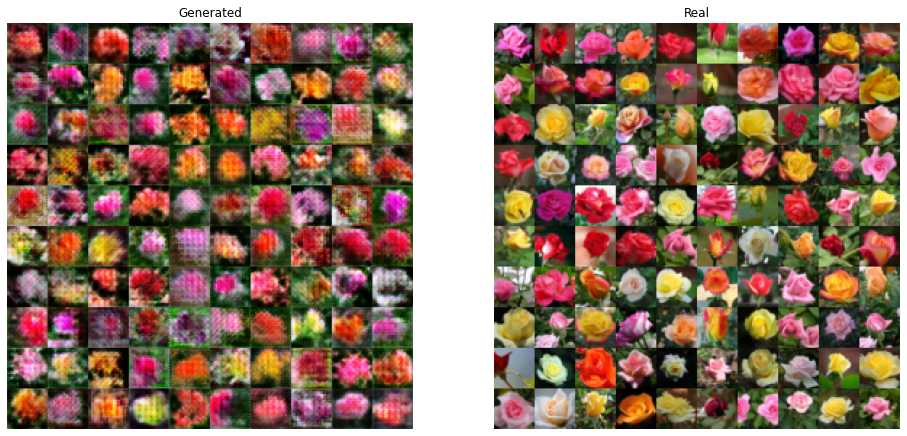

In [85]:
fig = comparison(ganW.generator, z_size, flowers_dl, device)

There are roses of different colors, and the look and feel is definitely there.

Did you notice a subtle *checkered pattern* in the fake images? That's a typical artifact of the **transposed convolutions**.

Let's take a closer look at some more examples:

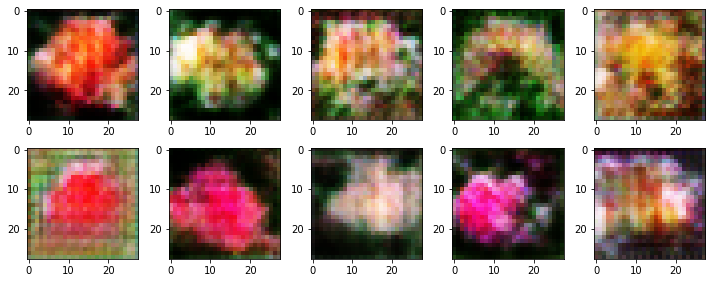

In [86]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
generated = (ganW.generator(latent_sample(10, z_size, 'normal').to(device))+1)/2
for i in range(10):
    show(generated[i], ax=axs[i])
fig.tight_layout()

## Final Thoughts

I believe this tutorial has **most of the necessary steps** one needs go to trough in order to **learn**, in a **structured** and **incremental** way, how to **develop build Generative Adversarial Networks using PyTorch**.

If you have any thoughts, comments or questions, please contact me on [LinkedIn](https://br.linkedin.com/in/dvgodoy) or [Twitter](https://twitter.com/dvgodoy).

<h1><center>THANK YOU!</center></h1>

<h3><center>
    If you liked my talk and are interested in learning more about PyTorch, check my book:
<br>
<br>
<a href="https://pytorchstepbystep.com">
<p align="center">
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2022/main/images/book_cover.png" width="60%">
</p>
<br>
    https://pytorchstepbystep.com
</a>
</center></h2>
